## Imports and Setup

In [1]:
import pandas as pd
import numpy as np
import nltk.tokenize
import itertools
import datetime
import torch

from sklearn.model_selection import train_test_split

from pathlib import Path

from fastai import *
from fastai.text import *

from copy import copy, deepcopy
from enum import Enum

### Model definitions
Define this notebooks "initializer model" (pretrained parameters and itos mapping) and the output model as well.

In [2]:
model_name = '4.0-LM-500k-nolines'
MODEL_PATH = Path(f'../data/models/{model_name}')
MODEL_PATH.mkdir(exist_ok=True)

init_model_name = 'wt103'
INIT_MODEL_PATH = Path(f'../data/models/{init_model_name}')

### Tokenization
To create the model's tokens with the correct train-test split, run the code below. Only needed once on the notebook's first ever run.

In [3]:
MODEL_FIRST_RUN = False

In [4]:
def tokenize_lyrics(lyrics, line_num=True):
    '''
    Tokenizes lyrics
    '''
    tk = nltk.tokenize.LineTokenizer(blanklines='keep')
    tokd = tk.tokenize(lyrics)
    
    re_tk = nltk.tokenize.RegexpTokenizer(r'\[[^\]]+\]|\w+|[\d\.,]+|\S+',
                                          discard_empty=False)
    re_tokd = re_tk.tokenize_sents(tokd)
    
    if line_num:
        [s.insert(0, f'xBOL {line_num+1}') for line_num, s in enumerate(re_tokd)] # insert start token for each line
    else:
        [s.insert(0, f'xBOL') for s in re_tokd] # insert start token for each line

    [s.append('xEOL') for s in re_tokd] # append end token for each line
    
    flat = list(itertools.chain(*re_tokd))
    flat.insert(0, 'xBOS')
    flat.append('xEOS')
    # lower case and de-space
    flat = [w.lower().replace(' ', '-') for w in flat]
    return flat

In [5]:
def process_tokens(model_path, small_corpus=False, line_num=True):
    '''
    500k link: https://storage.googleapis.com/capstone-deep-lyrics/lyrics-500k.csv
    108k link: https://storage.googleapis.com/w210-capstone/data/lyrics-valid.csv
    '''
    model_path = Path(model_path)
    model_path.mkdir(exist_ok=True)
    
    small_corpus_url = 'https://storage.googleapis.com/w210-capstone/data/lyrics-valid.csv'
    large_corpus_url = 'https://storage.googleapis.com/capstone-deep-lyrics/lyrics-500k.csv'

    # load scraped data
    if small_corpus:
        df = pd.read_csv(small_corpus_url,
                     header=None, escapechar='\\',
                     names=['msd_id', 'lyrics'])
    
    if not small_corpus:
        df = pd.read_csv(large_corpus_url, index_col=[0])
    
    # only keep lyrics with length < 5000
    df = df[df.lyrics.str.len() < 5000]
    print('Tokenizing...')
    df['tokd'] = df.lyrics.apply(tokenize_lyrics, line_num=line_num)
    df['tokd_len'] = df.tokd.apply(len)

    # split train/test
    df_train, df_test = train_test_split(df, test_size=0.2, random_state=2018)
    
    # tokens
    print('Saving...')
    tokens = np.array(df_train.tokd)
    np.save(model_path/'train_tok.npy', tokens)
    
    tokens = np.array(df_test.tokd)
    np.save(model_path/'valid_tok.npy', tokens)
    print('Done.')

In [6]:
if MODEL_FIRST_RUN:
    process_tokens(MODEL_PATH, small_corpus=False, line_num=False)

## Load Data

Now that we've created the tokens, let's load them into a `DataBunch` to train our LM further or generate text with a pre-trained LM.

In [7]:
if MODEL_FIRST_RUN:
    data_lm = TextLMDataBunch.from_tokens(MODEL_PATH,
                                          bs=128,
                                          max_vocab=20000)

In [27]:
if not MODEL_FIRST_RUN:
    data_lm = TextLMDataBunch.from_id_files(MODEL_PATH/'tmp')
    data_lm.path = MODEL_PATH

In [9]:
data_lm.train_ds.vocab_size

20002

## Model setup

In [29]:
GPU = True
DOWNLOAD_INIT_MODEL = False

In [30]:
learn = RNNLearner.language_model(data_lm,
                                  drop_mult=0.5)

In [12]:
# weights_url = 'https://storage.googleapis.com/capstone-deep-lyrics/3.2-ULMFiT-108k_best.pth'
# itos_url = 'https://storage.googleapis.com/capstone-deep-lyrics/3.2-ULMFiT-108k_best.pth'

# if DOWNLOAD_INIT_MODEL:
#     Path(MODEL_PATH/'models').mkdir(exist_ok=True)
#     download_url(weights_url, MODEL_PATH/f'models/{model_name}_best.pth', overwrite=False)
#     download_url(weights_url, MODEL_PATH/f'models/{model_name}_best.pth', overwrite=False)

In [13]:
untar_data('https://s3.amazonaws.com/fast-ai-modelzoo/wt103',
           dest=MODEL_PATH/'models'/f'{init_model_name}')

PosixPath('../data/models/4.0-LM-500k-nolines/models/wt103')

In [14]:
if MODEL_FIRST_RUN:
    learn.load_pretrained(MODEL_PATH/'models'/f'{init_model_name}/lstm_{init_model_name}.pth', 
                          MODEL_PATH/'models'/f'{init_model_name}/itos_{init_model_name}.pkl')

In [15]:
def cpu_load(self, name:PathOrStr):
    """Load model onto CPU that was trained on a GPU `name` from `self.model_dir`.
       We need these because the fastai load function doesn't allow for a remapping of the storage location."""
    self.model.load_state_dict(torch.load(self.path/self.model_dir/f'{name}.pth', map_location=lambda storage, loc: storage))

setattr(RNNLearner, 'cpu_load', cpu_load) #monkey patch onto our RNNLearner

In [31]:
if not MODEL_FIRST_RUN:
    if not GPU:
        learn.cpu_load(f'{model_name}_best')
    else:
        learn.load(f'{model_name}_best')

## Training

In [32]:
TRAIN = False

In [33]:
@dataclass
class SaveModel(LearnerCallback):
    """Save Latest Model"""
    def __init__(self, learn:Learner, model_name='saved_model'):
        super().__init__(learn)
        self.model_name = model_name
        self.model_date = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
        self.best_loss = None
        self.perplexity = []
        
    def on_epoch_end(self, epoch:int, metrics, last_metrics, **kwargs):
        loss, *_ = last_metrics
        perp = np.exp(loss)
        self.perplexity.append(perp)
        if self.best_loss == None or loss < self.best_loss:
            self.best_loss = loss
            self.learn.save(f'{self.model_name}_best')
        return False
    
    def on_train_end(self, epoch:int, **kwargs):
        self.learn.save(f'{self.model_name}_last')

In [34]:
save_callback = SaveModel(learn, model_name=f'{model_name}')

In [20]:
if TRAIN:
    learn.fit_one_cycle(1, 1e-2)

Total time: 1:10:44
epoch  train_loss  valid_loss  accuracy
1      2.838940    2.722366    0.486826  (1:10:44)



In [21]:
if TRAIN:
    learn.unfreeze()
    learn.fit(10, 1e-3, callbacks=[save_callback])

Total time: 11:47:17
epoch  train_loss  valid_loss  accuracy
1      2.754317    2.653085    0.497598  (1:10:42)
2      2.695400    2.614056    0.503625  (1:10:30)
3      2.670430    2.586842    0.507888  (1:10:42)
4      2.634851    2.567393    0.510872  (1:10:47)
5      2.616007    2.548971    0.513701  (1:10:39)
6      2.625343    2.538556    0.515376  (1:10:52)
7      2.615963    2.527840    0.517034  (1:10:49)
8      2.572687    2.516187    0.518694  (1:10:45)
9      2.562337    2.507846    0.520121  (1:10:37)
10     2.589528    2.503078    0.520817  (1:10:49)



In [22]:
print("best validation loss: ", learn.save_model.best_loss)

best validation loss:  2.5030775


In [24]:
#learn.save_encoder(f'{model_name}_encoder')

### Learning Loss

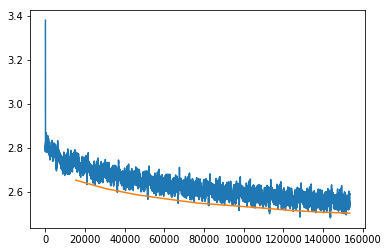

In [23]:
if TRAIN:
    learn.recorder.plot_losses()

### Model Output

In [35]:
MODEL_OUTPUT_NAME = MODEL_PATH/'models'/f'{model_name}_best.pth'
CLOUD_STORAGE = f'gs://w210-capstone/models/{model_name}_best.pth'

In [36]:
!gsutil cp $MODEL_OUTPUT_NAME $CLOUD_STORAGE

Copying file://../data/models/4.0-LM-500k-nolines/models/4.0-LM-500k-nolines_best.pth [Content-Type=application/octet-stream]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

|
Operation completed over 1 objects/150.5 MiB.                                    


## Text Generation

In [37]:
def generate_step(learner, context, context_length, temp=1):

    model = learner.model
    
    if GPU:
        context = LongTensor(context[-context_length:]).view(-1,1).cuda()
    else:
        context = LongTensor(context[-context_length:]).view(-1,1).cpu()
    
    context = torch.autograd.Variable(context)
    
    model.reset()
    model.eval()

    # forward pass the "context" into the model
    result, *_ = model(context)
    result = result[-1]

    # set unk and pad to 0 prob
    # i.e. never pick unknown or pad
    result[0] = -np.inf
    result[1] = -np.inf

    # softmax and normalize
    probabilities = F.softmax(result/temp, dim=0)
    probabilities = np.asarray(probabilities.detach().cpu(), dtype=np.float)
    probabilities /= np.sum(probabilities) 
    return probabilities

def print_words(context):
    for i in range(len(context)):
        
        step = context[i]

        word = data_lm.valid_ds.vocab.textify([step])

        if word == 'xeol':
            word = '\n'
        elif 'xbol' in word:
            word = word
        elif word == 'xeos': 
            print(word)
            break
            
        print(word, end=' ')   

def generate_text(learner, seed_text=['xbos'], max_len=500, GPU=False, context_length=20, beam_width=5, verbose=True, temp=1):
    """Generates text with a given learner and returns best options.

    Parameters
    ----------
    learner : RNNLearner Language Model (RNNLearner.language_model())
        Fastai RNNLearner with tokenized language model data already loaded 
        
    seed_text : list or str
        List of strings where each item is a token. (e.g. ['the', 'cat']) or string that is split on white space

    max_len : int
        Number of words in generated sequence
        
    gpu : bool
        If you're using a GPU or not...
    
    context_length : int
        Amount of words that get input as "context" into the model. Set to 0 for no limit   
        
    beam_width : int
        How many new word indices to try out...computationally expensive
    
    verbose : bool
        If True, prints every possible context for a given word cycle

    temperature : float
        Scales the logits before softmax. A higher temp (>1) increases variety whereas a low temp (<=1) will often result in a loop

    Returns
    -------
    context_and_scores : list of lists
        Returns a sorted list of the entire tree search of contexts and their respective scores in the form:
        [[context, score], [context, score], ..., [context, score]]
    """
        
    if isinstance(seed_text, str):
        seed_text = data_lm.train_ds.vocab.numericalize(seed_text.split(' '))
    
    
    # Width for the beam search, to be externalized along with general decoding
    beam_width = beam_width
    
    # List of candidate word sequence. We'll maintain #beam_width top sequences here.
    # The context is a list of words, the scores are the sum of the log probabilities of each word
    context_and_scores = [[seed_text, 0.0]]
    
    # Loop over max number of words
    for word_number in range(max_len):
        if verbose: print(f'Generating word: {word_number+1} / {max_len}')

        candidates = []
        
        # For each possible context that we've generated so far, generate new probabilities, 
        # and pick an additional #beam_width next candidates
        for i in range(len(context_and_scores)):
            # Get a new sequence of word indices and log-probability
            # Example: [[2, 138, 661], 23.181717]
            context, score = context_and_scores[i]
            
            # Obtain probabilities for next word given the context 
            probabilities = generate_step(learner, context, context_length, temp)

            # Multinomial draw from the probabilities
            multinom_draw = np.random.multinomial(beam_width, probabilities)
            top_probabilities = np.argwhere(multinom_draw != 0).flatten()
                        
            #For each possible new candidate, update the context and scores
            for j in range(len(top_probabilities)):
                next_word_idx = top_probabilities[j]
                new_context = context + [next_word_idx]
                candidate = [new_context, (score - np.log(probabilities[next_word_idx]))]
                candidates.append(candidate)
        
        #update the running tally of context and scores and sort by probability of each entry
        context_and_scores = candidates
        context_and_scores = sorted(context_and_scores, key = lambda x: x[1]) #sort by top entries
#         np.random.shuffle(context_and_scores)

        context_and_scores = context_and_scores[:15] #for now, only keep the top 15 to speed things up but we can/should change this to beam_width or something else
        
        if verbose:
            for context, score in context_and_scores:
                print_words(context)
                print('\n')
    
    return context_and_scores
    

In [42]:
final_scores = generate_text(learn, GPU=GPU, seed_text='xbos xbol', max_len=80, context_length=40, beam_width=3, verbose=False, temp=1.5)

In [43]:
#print all of the final options of songs
for song, score in final_scores:
    print_words(song)
    print(score)
    print('\n')

xbos xbol hop off put it on ice 
 xbol if you 've got my heart broken 
 xbol i don 't know where you 've gone to 
 xbol no , if you don 't like my love 
 xbol then i don 't, i just don 't know ... 
 xbol 
 xbol oh baby 
 xbol you didn 't have to do everything you do 
 xbol you didn 't have to make up your mind 
 xbol to 210.72907546229337


xbos xbol hop off put it on ice 
 xbol if you 've got my heart broken 
 xbol i don 't know where you 've gone to 
 xbol no , if you don 't like my love 
 xbol then i don 't, i just don 't know ... 
 xbol 
 xbol oh baby 
 xbol you didn 't have to do everything you do 
 xbol you didn 't have to make up your mind 
 xbol so 211.5495533756906


xbos xbol hop off put it on ice 
 xbol if you 've got my heart broken 
 xbol i don 't know where you 've gone to 
 xbol no , if you don 't like my love 
 xbol then i don 't, i just don 't know ... 
 xbol 
 xbol oh baby 
 xbol you didn 't have to do it as far as i do 
 xbol you didn 't have to do 
 xbol 
 212.44683